In [3]:
pip install opencv-python

     |████████████████████████████████| 60.3 MB 9.4 MB/s eta 0:00:011     |████████████████████████████████| 60.1 MB 9.4 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import os 
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
%matplotlib inline

2021-11-30 16:42:02.181157: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/aziker/anaconda3/envs/metis/lib/python3.8/site-packages/cv2/../../lib64:
2021-11-30 16:42:02.181216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path = 'Leaf_outlines/'

In [3]:
training_data = []
ground_truth = []
for img in os.listdir(path):
    pic = cv2.imread(os.path.join(path,img))
    pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
    pic = cv2.resize(pic,(80,80))
    training_data.append([pic])
    ground_truth.append(img[0:4])

In [4]:
ground_truth[0]

'Pset'

In [5]:
#Need to make integers for to_categorical later, ignoring pfii because it will merge with Pfoe later
d = {}
counter = 0
for i in ground_truth:
    if i[:4] == 'Pfii':
        continue
    elif i not in d.keys():
        d[i] = counter
        counter += 1
    else:
        continue
d

{'Pset': 0,
 'Pker': 1,
 'Pcoc': 2,
 'Pmin': 3,
 'Prub': 4,
 'Pmis': 5,
 'Pmal': 6,
 'Pcor': 7,
 'Pmie': 8,
 'Pmuc': 9,
 'Pcri': 10,
 'Psid': 11,
 'Pfoe': 12,
 'Pgib': 13,
 'Pmol': 14,
 'Prac': 15,
 'Pala': 16,
 'Psub': 17,
 'Pedm': 18,
 'Phat': 19,
 'Ptlo': 20,
 'Pbif': 21,
 'Pgra': 22,
 'Pcap': 23,
 'Pvil': 24,
 'Ptri': 25,
 'Pmic': 26,
 'Pmaf': 27,
 'Pame': 28,
 'Porg': 29,
 'Pact': 30,
 'Pcae': 31,
 'Pcin': 32,
 'Plig': 33,
 'Pten': 34,
 'Pgal': 35,
 'Ppoh': 36,
 'Pmor': 37,
 'Pnit': 38,
 'Pedu': 39}

In [30]:
np.save(os.path.join(path,'leaf_images'),np.array(training_data))

In [31]:
np.save(os.path.join(path,'leaf_truths'),np.array(ground_truth))

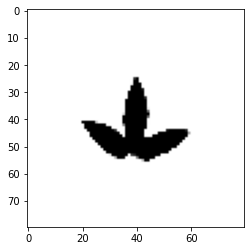

In [6]:
plt.imshow(np.array(training_data[0]).reshape(80,80,3))

In [7]:
import pandas as pd

In [8]:
data = {'image': training_data, 'species': ground_truth}
df = pd.DataFrame(data=data)

In [9]:
'''in read.me of original data, Pfii and Pfoe both represent the same
    species, relabelling to reflect this'''                   
df.species.replace({'Pfii': 'Pfoe'}, inplace=True)                          

In [11]:
#rep#54lacing species name with integer value for later conversion to categoricals
df.species.replace(d, inplace=True)    

In [12]:
df.species.max()

39

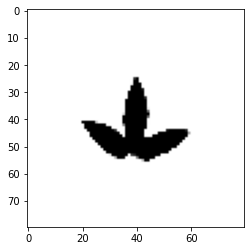

In [56]:
plt.imshow(np.array(df.image[0]).reshape(80,80,3))

In [13]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical


X_vals, y_vals = np.array(training_data), df.species.astype(np.int64)

# 28x28 images, with grey scale pixel strengths repeated across 3 channels for color representation
X_vals = X_vals.reshape((-1,80,80,3)) 
### REPEAT VALUES ACROSS 2 ADDITIONAL CHANNELS

X_train, X_test, y_train, y_test = (train_test_split(X_vals, y_vals, 
                                                     test_size = .2, random_state = 42))

# 2D (one-hot encoded) representation of multiclass target 
y_train_cat = to_categorical(y_train)

In [14]:
y_train_cat.shape

(2635, 40)

In [122]:
y_vals[345]

40

In [117]:
a = pd.get_dummies(df.species)
a.shape

(3294, 40)

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer
'''
 In this network structure, note that we follow the typical CNN heuristic of 
 gradually reducing width and height dimenions over time with max pooling
 (typically by a factor of 2), but increasing the filter depth dimension 
 to find increasingly specific patterns. These models are typically compromised 
 of a series of convolutional blocks followed by a flattening operation and 
 a series of fully connected layers at the terminus.
'''

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))

# Conv block 1.  You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 2 - note we increase filter dimension as we move
# further into the network. You can add more conv steps to
# each block to increase model capacity.
NN.add(Conv2D(filters=60, kernel_size=3, activation='relu', padding='same'))
# NN.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
NN.add(MaxPooling2D())

# Conv block 3 - The conv blocks should be ended with either a flatten
# layer or a global pooling layer. These transform the 2D layers to 1D
# to match the following dense layers.
NN.add(Conv2D(filters=90, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())

# Fully connected block - flattening followed by dense and output layers
NN.add(Flatten())
NN.add(Dense(80, activation='relu'))
NN.add(Dense(40, activation='softmax'))  # 40 target classes

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 80, 80, 30)        840       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 40, 40, 30)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 40, 40, 60)        16260     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 20, 20, 60)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 20, 20, 90)        48690     
_________________________________________________________________
global_average_pooling2d_3 ( (None, 90)                0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 90)               

In [28]:
from sklearn.metrics import accuracy_score

preds = np.argmax(NN.predict(X_test), axis=1)
accuracy_score(y_test, preds)


0.6312594840667678

Text(0.5, 1.0, 'confusion matrix')

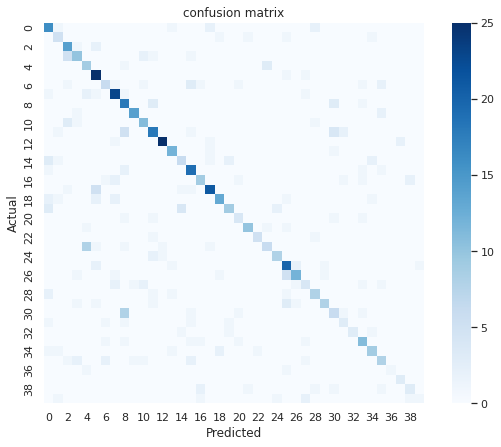

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lr_confusion = confusion_matrix(y_test, preds)
lr_confusion

sns.set(rc={'figure.figsize':(10,7)})
sns.heatmap(lr_confusion, cmap=plt.cm.Blues,fmt='d', square=True,);

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('confusion matrix')

We have a basic model up and running that demonstrates learning over the epochs, but also seeing some serious overfitting.  First step will be to adjust the architecture via transfer learning and see if a new architecture will improve performance.

In [36]:
from tensorflow.keras.applications import mobilenet_v2

base_model = mobilenet_v2.MobileNetV2(
    weights='imagenet',
    input_shape=(80, 80, 3),
    include_top=False)  

base_model.trainable = False

In [37]:
inputs = keras.Input(shape=(80, 80, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(units=80, activation = 'relu')(x)

outputs = keras.layers.Dense(units=40, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

In [38]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
model.summary()
model.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 80)                102480    
_________________________________________________________________
dense_10 (Dense)             (None, 40)                3240      
Total params: 2,363,704
Trainable params: 105,720
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/100
62/62 [==============================] - 6s 62ms/step - loss: 3.3287 - accuracy: 0.1513 - val_los

mobilenetV2 performed worse than the base model, will try a more robust model, Xception

In [39]:
from tensorflow.keras.applications import Xception

base_model = Xception(
    weights='imagenet',
    input_shape=(80, 80, 3),
    include_top=False)  

base_model.trainable = False

83697664/83683744 [==============================] - 8s 0us/step


In [40]:
inputs = keras.Input(shape=(80, 80, 3))

x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)

x = keras.layers.Dense(units=80, activation = 'relu')(x)

outputs = keras.layers.Dense(units=40, activation = 'softmax')(x)
model = keras.Model(inputs, outputs)

In [41]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
model.summary()
model.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 80, 80, 3)]       0         
_________________________________________________________________
xception (Functional)        (None, 3, 3, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 2048)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 80)                163920    
_________________________________________________________________
dense_12 (Dense)             (None, 40)                3240      
Total params: 21,028,640
Trainable params: 167,160
Non-trainable params: 20,861,480
_________________________________________________________________
Epoch 1/100
62/62 [==============================] - 15s 225ms/step - loss: 9.5730 - accuracy: 0.0314 - val

Going back to the base model, and attempting regularization in the dense layer to try and reduce overfitting

In [43]:
from tensorflow.keras import regularizers

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))


NN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=60, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=90, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())


NN.add(Flatten())

NN.add(Dense(80, activation='relu', kernel_regularizer='l2'))#added l2 regularizer here

NN.add(Dense(40, activation='softmax'))  # 40 target classes

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 80, 80, 30)        840       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 40, 40, 30)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 40, 40, 60)        16260     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 20, 20, 60)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 20, 20, 90)        48690     
_________________________________________________________________
global_average_pooling2d_8 ( (None, 90)                0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 90)               

accuracy went down for training set but didnt go up for validation, will try regulizer plus dropout

In [45]:
from tensorflow.keras.layers import Dropout

NN = Sequential()

NN.add(InputLayer(input_shape=X_train.shape[1:]))


NN.add(Conv2D(filters=30, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=60, kernel_size=3, activation='relu', padding='same'))

NN.add(MaxPooling2D())


NN.add(Conv2D(filters=90, kernel_size=3, activation='relu', padding='same'))

NN.add(GlobalAveragePooling2D())


NN.add(Flatten())

NN.add(Dense(80, activation='relu', kernel_regularizer='l2'))

NN.add(Dropout(0.05)) #added dropout here

NN.add(Dense(40, activation='softmax'))  # 40 target classes

NN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)
NN.summary()
NN.fit(X_train, y_train_cat, epochs=100, verbose=1, validation_split=0.25,
       callbacks=[
           keras.callbacks.ModelCheckpoint(
               'models/mnist.{epoch:02d}-{val_loss:.2f}.hdf5',
               save_best_only=True)
       ])  # track progress as we fit

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 80, 80, 30)        840       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 40, 40, 30)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 40, 40, 60)        16260     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 20, 20, 60)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 20, 20, 90)        48690     
_________________________________________________________________
global_average_pooling2d_9 ( (None, 90)                0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 90)               

In [44]:
from tensorflow.keras.layers import Dropout